In [78]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, utils
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import pickle
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
# import wget
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from keras.models import load_model

In [66]:
test_df = {'Label': [], 'Text': []}
with open('test.ft.txt', encoding='utf-8') as test_file:
    for line in test_file:
        test_df['Label'].append(line.rstrip()[9])
        test_df['Text'].append(line.rstrip()[10:])
test_df = pd.DataFrame(test_df)
test_df.to_csv('test.csv', index=False, encoding='utf-8')


In [67]:
test = pd.read_csv('test.csv')

In [68]:
test.head()

,Label,Text
0,2,Great CD: My lovely Pat has one of the GREAT ...
1,2,One of the best game music soundtracks - for ...
2,1,Batteries died within a year ...: I bought th...
3,2,"works fine, but Maha Energy is better: Check ..."
4,2,Great for the non-audiophile: Reviewed quite ...


In [71]:
len(test)

400000

In [70]:
test['Label'].value_counts()

Label
2    200000
1    200000
Name: count, dtype: int64

In [73]:
train_df = {'Label': [], 'Text': []}
with open('train.ft.txt', encoding='utf-8') as train_file:
    for line in train_file:
        train_df['Label'].append(line.rstrip()[9])
        train_df['Text'].append(line.rstrip()[10:])
train_df = pd.DataFrame(train_df)
train_df.to_csv('train.csv', index=False, encoding='utf-8')

In [75]:
train = pd.read_csv('train.csv')

In [76]:
len(train)

3600000

In [77]:
train.head()

,Label,Text
0,2,Stuning even for the non-gamer: This sound tr...
1,2,The best soundtrack ever to anything.: I'm re...
2,2,Amazing!: This soundtrack is my favorite musi...
3,2,Excellent Soundtrack: I truly like this sound...
4,2,"Remember, Pull Your Jaw Off The Floor After H..."


In [78]:
train['Label'].value_counts()

Label
2    1800000
1    1800000
Name: count, dtype: int64

In [21]:
# import gdown

# # Replace 'FILE_ID' with your actual file ID
# file_id = '1tip0zqRVtNUf-kT-CIfEvUBB52l-hzBW'
# url = f'https://drive.google.com/uc?id={file_id}'
# output = 'test-2.csv'  # Desired local filename

# # Download the file
# gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1tip0zqRVtNUf-kT-CIfEvUBB52l-hzBW
From (redirected): https://drive.google.com/uc?id=1tip0zqRVtNUf-kT-CIfEvUBB52l-hzBW&confirm=t&uuid=3125d1a9-7400-41bd-8747-ea6d3ef696e5
To: e:\10k\DNN\LSTM-sentiment-analysis\test-2.csv
100%|██████████| 176M/176M [00:47<00:00, 3.69MB/s] 


'test-2.csv'

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
# Text preprocessing
def text_preprocess(text):
    text = contractions.fix(text)
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = text.lower()
    stop_words = stopwords.words('english')
    stop_words.remove('not')
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text if word not in stop_words])
    return text

In [9]:
test['Text'] = tqdm(test['Text'].apply(text_preprocess))

100%|██████████| 400000/400000 [00:00<00:00, 2402277.24it/s]


In [11]:
tqdm.pandas()
train['Text'] = train['Text'].progress_apply(text_preprocess)

100%|██████████| 3600000/3600000 [39:28<00:00, 1519.64it/s] 


In [13]:
test.to_csv('test_preprocessed.csv', index=False, encoding='utf-8')

In [14]:
train.to_csv('train_preprocessed.csv', index=False, encoding='utf-8')

In [60]:
train = pd.read_csv('train_preprocessed.csv')
test = pd.read_csv('test_preprocessed.csv')

In [61]:
# Getting text and label
train_text = train_sample['Text'].values
train_label = train_sample['Label'].values

test_text = test_sample['Text'].values
test_label = test_sample['Label'].values

In [62]:
# Managing labels
le = LabelEncoder()
train_label = le.fit_transform(train_label)
test_label = le.fit_transform(test_label)

train_label = to_categorical(train_label)
test_label = to_categorical(test_label)

In [63]:
# Getting text max length
max_len = max([len(i) for i in train_text])
max_len

916

In [64]:
# Indicating num_words due to very huge vocab_size
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(train_text)

vocab_size = len(tokenizer.word_index)

vocab_size

409855

In [65]:
# Sequencing
train_text = tokenizer.texts_to_sequences(train_text)
test_text = tokenizer.texts_to_sequences(test_text)

In [66]:
# Padding
train_text = pad_sequences(train_text, maxlen=max_len)
test_text = pad_sequences(test_text, maxlen=max_len)

In [85]:
# Saving final version of data as numpy
np.save('final_train_text.npy', train_text)
np.save('final_train_labels.npy', train_label)
np.save('final_test_text.npy', test_text)
np.save('final_test_labels.npy', test_label)

In [86]:
train_text_df = pd.DataFrame(train_text)
train_label_df = pd.DataFrame(train_label)
test_text_df = pd.DataFrame(test_text)
test_label_df = pd.DataFrame(test_label)


In [87]:
train_text_df.to_csv('final_train_text.csv', index=False)
train_label_df.to_csv('final_train_label.csv', index=False)
test_text_df.to_csv('final_test_text.csv', index=False)
test_label_df.to_csv('final_test_label.csv', index=False)

#### Model

In [ ]:
# Loading GloVe pretrained model
embedding_dim = 300
embedding_index = {}
with open('glove.840B.300d.txt', encoding='utf-8') as file:
    for line in tqdm(file):
        values = line.split() # Splitting the word key from the coeff values
        word = values[0]
        try:
            coeff = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coeff
        except ValueError as e:
            print(f'Error in word {word}: {e}')

53709it [00:08, 4749.95it/s] 

Error in word .: could not convert string to float: '.'


130355it [00:14, 10967.38it/s]

Error in word at: could not convert string to float: 'name@domain.com'


152842it [00:17, 11394.67it/s]

Error in word .: could not convert string to float: '.'


203197it [00:21, 12598.48it/s]

Error in word to: could not convert string to float: 'name@domain.com'


212309it [00:22, 13004.72it/s]

Error in word .: could not convert string to float: '.'


222678it [00:23, 12044.33it/s]

Error in word .: could not convert string to float: '.'


255781it [00:25, 12499.07it/s]

Error in word email: could not convert string to float: 'name@domain.com'


367704it [00:36, 11538.83it/s]

Error in word or: could not convert string to float: 'name@domain.com'


534663it [00:51, 12118.96it/s]

Error in word contact: could not convert string to float: 'name@domain.com'


719266it [01:08, 10875.44it/s]

Error in word Email: could not convert string to float: 'name@domain.com'


996517it [01:36, 11668.56it/s]

Error in word on: could not convert string to float: 'name@domain.com'


1125539it [01:48, 12641.21it/s]

Error in word At: could not convert string to float: 'Killerseats.com'


1149917it [01:50, 11197.92it/s]

Error in word by: could not convert string to float: 'name@domain.com'


1354026it [02:09, 12736.14it/s]

Error in word in: could not convert string to float: 'mylot.com'


1502342it [02:28, 12735.75it/s]

Error in word emailing: could not convert string to float: 'name@domain.com'


1535657it [02:31, 11872.93it/s]

Error in word Contact: could not convert string to float: 'name@domain.com'


1900553it [03:06, 11247.24it/s]

Error in word at: could not convert string to float: 'name@domain.com'


1922068it [03:08, 11186.49it/s]

Error in word •: could not convert string to float: 'name@domain.com'


2059999it [03:23, 11189.72it/s]

Error in word at: could not convert string to float: 'Amazon.com'


2166932it [03:35, 11643.34it/s]

Error in word is: could not convert string to float: 'name@domain.com'


2196017it [03:38, 10045.21it/s]


In [44]:
embedding_matrix = np.zeros((max_words, embedding_dim)) # Embedding matrix to be put in the embedding layer
for word, i in tqdm(tokenizer.word_index.items()):
    if i < max_words: # if word index is within range
        embedding_vector = embedding_index.get(word) # Get the word parameters from GloVe
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # embedding parameters of specific word in our corpus with those from the pretrained embeddings

100%|██████████| 409855/409855 [00:07<00:00, 57286.50it/s] 


In [49]:
# Saving embedding matrix
np.save('embedding_matrix.npy', embedding_matrix)


In [40]:
#Loading embedding matrix
embedding_matrix = np.load('embedding_matrix.npy')

In [67]:
# Define the sample size
sample_size = 1000  # Adjust the sample size as needed

# Take samples
train_sample_indices = np.random.choice(len(train_text), sample_size, replace=False)
test_sample_indices = np.random.choice(len(test_text), sample_size, replace=False)

train_sample_texts = train_text[train_sample_indices]
train_sample_labels = train_label[train_sample_indices]

test_sample_texts = test_text[test_sample_indices]
test_sample_labels = test_label[test_sample_indices]

# Verify the shapes of the samples
print(f'Train Sample Texts Shape: {train_sample_texts.shape}')
print(f'Train Sample Labels Shape: {train_sample_labels.shape}')
print(f'Test Sample Texts Shape: {test_sample_texts.shape}')
print(f'Test Sample Labels Shape: {test_sample_labels.shape}')


Train Sample Texts Shape: (1000, 916)
Train Sample Labels Shape: (1000, 2)
Test Sample Texts Shape: (1000, 916)
Test Sample Labels Shape: (1000, 2)


In [88]:
train_text = pd.read_csv('final_train_text.csv')
train_label = pd.read_csv('final_train_label.csv')
test_text = pd.read_csv('final_test_text.csv')
test_label = pd.read_csv('final_test_label.csv')
# Convert back to NumPy arrays
train_text = train_text.values
train_label = train_label.values
test_text = test_text.values
test_label = test_label.values


In [89]:
# Define the sample size
sample_size = 1000  # Adjust the sample size as needed

# Take samples
train_sample_indices = np.random.choice(len(train_text), sample_size, replace=False)
test_sample_indices = np.random.choice(len(test_text), sample_size, replace=False)

train_sample_texts = train_text[train_sample_indices]
train_sample_labels = train_label[train_sample_indices]

test_sample_texts = test_text[test_sample_indices]
test_sample_labels = test_label[test_sample_indices]

# Verify the shapes of the samples
print(f'Train Sample Texts Shape: {train_sample_texts.shape}')
print(f'Train Sample Labels Shape: {train_sample_labels.shape}')
print(f'Test Sample Texts Shape: {test_sample_texts.shape}')
print(f'Test Sample Labels Shape: {test_sample_labels.shape}')

Train Sample Texts Shape: (1000, 916)
Train Sample Labels Shape: (1000, 2)
Test Sample Texts Shape: (1000, 916)
Test Sample Labels Shape: (1000, 2)


In [68]:
embedding_dim = 300
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(LSTM(64, return_sequences=True, dropout=.2, recurrent_dropout=.2))
model.add(Dropout(.2))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(len(le.classes_), activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 916, 300)          1500000   
                                                                 
 lstm_4 (LSTM)               (None, 916, 64)           93440     
                                                                 
 dropout_4 (Dropout)         (None, 916, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                

In [69]:
## Adding checkpoints and learning rate optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lr = ReduceLROnPlateau(monitor='val_accuracy', min_lr=.00001, factor=.3)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [70]:
history = model.fit(train_sample_texts, train_sample_labels, epochs=5, batch_size=128,validation_split=.2, callbacks=[lr, checkpoint])

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.5825 
Epoch 1: val_accuracy improved from -inf to 0.71000, saving model to best_model.h5
7/7 [==============================] - 136s 18s/step - loss: 0.6796 - accuracy: 0.5825 - val_loss: 0.6327 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 2/5
7/7 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.7075 
Epoch 2: val_accuracy improved from 0.71000 to 0.77000, saving model to best_model.h5
7/7 [==============================] - 120s 17s/step - loss: 0.6079 - accuracy: 0.7075 - val_loss: 0.5309 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 3/5
7/7 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.7337 
Epoch 3: val_accuracy improved from 0.77000 to 0.80000, saving model to best_model.h5
7/7 [==============================] - 137s 20s/step - loss: 0.5393 - accuracy: 0.7337 - val_loss: 0.4904 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/5
7/7 [============================

#### Model evaluation

In [71]:
# Saving history
with open('training_history-sample1.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [80]:
# Loading best model
best_model = models.load_model('best_model-sample1.h5')

In [81]:
loss, accuracy = best_model.evaluate(test_sample_texts, test_sample_labels)
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Test loss: {loss:.4f}')

32/32 [==============================] - 18s 523ms/step - loss: 0.5132 - accuracy: 0.7550
Test accuracy: 75.50%
Test loss: 0.5132


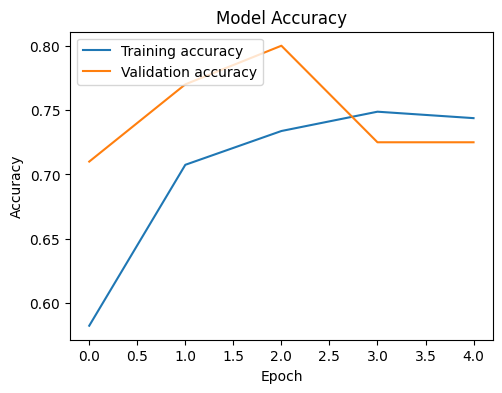

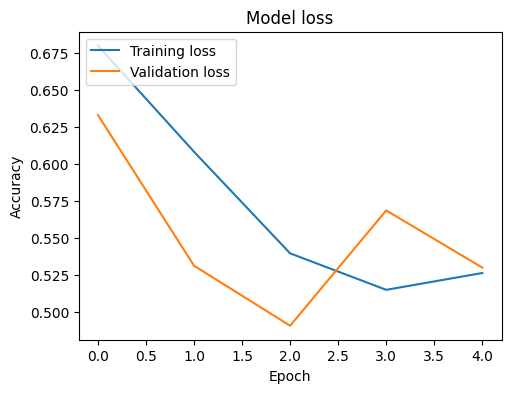

In [82]:
# Depicting history
# Accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')


32/32 [==============================] - 19s 533ms/step


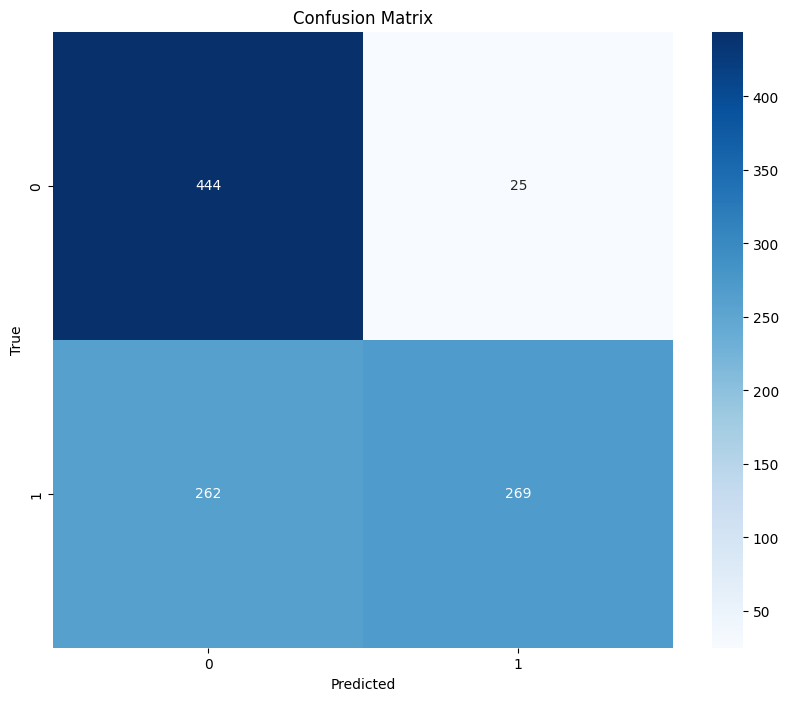

In [83]:
# Getting label predictions
pred = model.predict(test_sample_texts)
pred_label = np.argmax(pred, axis=1)
true_label = np.argmax(test_sample_labels, axis=1)

cm = confusion_matrix(true_label, pred_label)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [84]:
# Classification report
cr = classification_report(true_label, pred_label)
print(cr)

              precision    recall  f1-score   support

           0       0.63      0.95      0.76       469
           1       0.91      0.51      0.65       531

    accuracy                           0.71      1000
   macro avg       0.77      0.73      0.70      1000
weighted avg       0.78      0.71      0.70      1000



#### Editing model

In [ ]:
# Increasing model depth, # epochs and increasing data samples

In [ ]:
# Define the sample size
sample_percentage = .2  # Adjust the sample size as needed

train_sample_size = int(sample_percentage * len(train_text))
test_sample_size = int(sample_percentage * len(test_text))

# Take samples
train_sample_indices = np.random.choice(len(train_text), train_sample_size, replace=False)
test_sample_indices = np.random.choice(len(test_text), test_sample_size, replace=False)

train_sample_texts = train_text[train_sample_indices]
train_sample_labels = train_label[train_sample_indices]

test_sample_texts = test_text[test_sample_indices]
test_sample_labels = test_label[test_sample_indices]

# Verify the shapes of the samples
print(f'Train Sample Texts Shape: {train_sample_texts.shape}')
print(f'Train Sample Labels Shape: {train_sample_labels.shape}')
print(f'Test Sample Texts Shape: {test_sample_texts.shape}')
print(f'Test Sample Labels Shape: {test_sample_labels.shape}')
print(f'Total training data size: {len(train_text)}')


Train Sample Texts Shape: (72000, 916)
Train Sample Labels Shape: (72000, 2)
Test Sample Texts Shape: (8000, 916)
Test Sample Labels Shape: (8000, 2)
Total training data size: 360000


In [ ]:
embedding_dim = 300
max_words = 5000
max_len = 916
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(LSTM(128, return_sequences=True, dropout=.2, recurrent_dropout=.2))
model.add(Dropout(.2))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 916, 300)          1500000   
                                                                 
 lstm (LSTM)                 (None, 916, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 916, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                

In [ ]:
## Adding checkpoints and learning rate optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lr = ReduceLROnPlateau(monitor='val_accuracy', min_lr=.00001, factor=.3)
checkpoint = ModelCheckpoint('best_model-sample2.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(train_sample_texts, train_sample_labels, epochs=10, batch_size=128,validation_split=.2, callbacks=[lr, checkpoint])

Epoch 1/10
450/450 [==============================] - ETA: 0s - loss: 0.3615 - accuracy: 0.8405
Epoch 1: val_accuracy improved from -inf to 0.88167, saving model to best_model-sample2.h5
450/450 [==============================] - 713s 2s/step - loss: 0.3615 - accuracy: 0.8405 - val_loss: 0.2911 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 2/10
450/450 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.8829
Epoch 2: val_accuracy improved from 0.88167 to 0.89188, saving model to best_model-sample2.h5
450/450 [==============================] - 713s 2s/step - loss: 0.2821 - accuracy: 0.8829 - val_loss: 0.2683 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 3/10
450/450 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.8956
Epoch 3: val_accuracy improved from 0.89188 to 0.89819, saving model to best_model-sample2.h5
450/450 [==============================] - 712s 2s/step - loss: 0.2564 - accuracy: 0.8956 - val_loss: 0.2492 - val_accuracy: 0.8982 - lr: 0.001

#### Model evaluation

In [ ]:
# Saving history
with open('training_history-sample2.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
# Loading best model
best_model = models.load_model('best_model-sample2.h5')

In [ ]:
loss, accuracy = best_model.evaluate(test_sample_texts, test_sample_labels)
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Test loss: {loss:.4f}')

250/250 [==============================] - 66s 260ms/step - loss: 0.2279 - accuracy: 0.9074
Test accuracy: 90.74%
Test loss: 0.2279


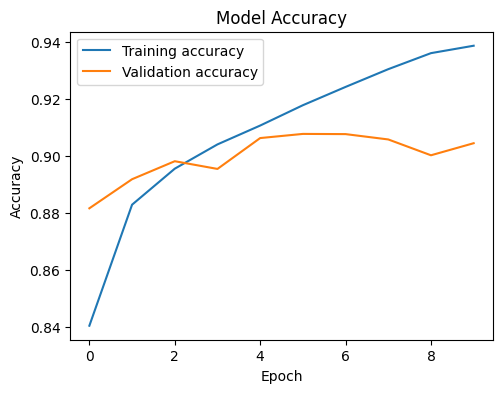

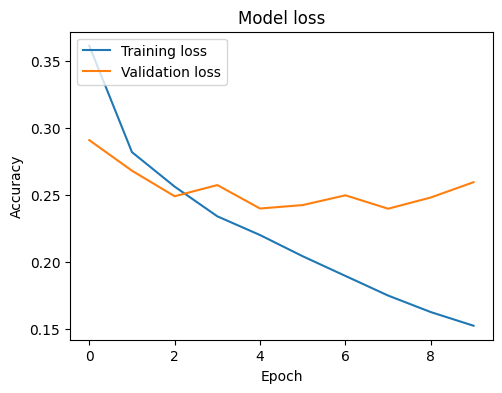

In [ ]:
# Depicting history
# Accuracy
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')


250/250 [==============================] - 65s 259ms/step


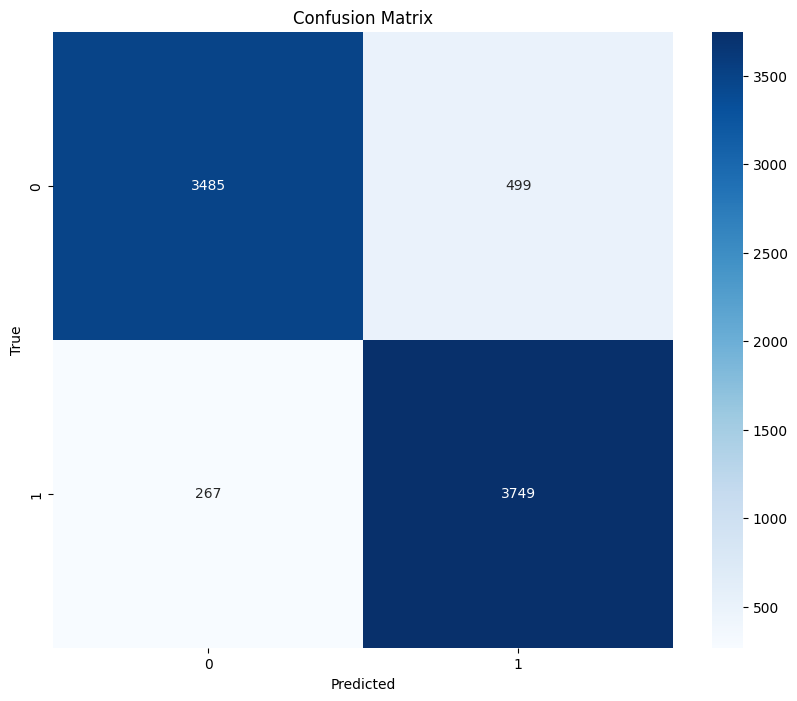

In [ ]:
# Getting label predictions
pred = model.predict(test_sample_texts)
pred_label = np.argmax(pred, axis=1)
true_label = np.argmax(test_sample_labels, axis=1)

cm = confusion_matrix(true_label, pred_label)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Classification report
cr = classification_report(true_label, pred_label)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      3984
           1       0.88      0.93      0.91      4016

    accuracy                           0.90      8000
   macro avg       0.91      0.90      0.90      8000
weighted avg       0.91      0.90      0.90      8000



Due to limitations of free use of GPU on Google collab, running the model on a larger sample of our data coudn't be acheived